# Indeed Job Scraper

Having grown up in Penticton, BC, many of my friends and family (myself included) have noted that there are very few young working adults in town. After having some discussions with my hometown friends, it seems to be a common opinion that the reason for this is that there are very fell well-paying jobs. I now live in Victoria, BC and decided that it would be interesting to compare the number of jobs by sector and their average wages to see if this opinion holds any truth. 

The purpose of this project is to create a job scraper for www.indeed.com (note that this was the canadian version of the website). The intent is to obtain all the job postings in the town of Penticton and the city of Victoria to compare current job availability in different sectors and average available job wages. 

## Building the Scraper

### Import Libraries for Scraping

In [1]:
import csv
from datetime import datetime
import requests
import time
from bs4 import BeautifulSoup

### Obtaining and Testing Indeed's URL

First we'll create a function to generate a valid URL passing position, location and industry values. 

In [2]:
def get_url(position, location, industry):
    """Generate a url from position and location"""
    template = 'https://ca.indeed.com/jobs?q={}&l={}&sc=0kf%3Acmpsec({})%3B'
    url = template.format(position, location, industry)
    return url

Unfortunately, Indeed's URL format utilizes specific 5 character codes to represent the different industry sectors classified. I had to manually cycle through and copy these 5 character codes to create a dictionary which relates them. 

In [3]:
industry = {"Retail & Wholesale": "48BZP","Healthcare": "22VKN",
            "Restaurants & Food Service":"W2F4E","Construction, Repair & Maintenance Services":"NTW8X",
           "Transportation & Logistics": "P634J", "Information Technology": "NKR5F", "Hotel & Travel Accommodation":"X42V4",
           "Manufacturing":"CPGHF","Non-profit & NGO":"ZMM32","Human Resources & Staffing":"Q3FC3",
           "Government & Public Administration":"B23RH","Real Estate":"S7KHR","Finance":"MSQWR", 
            "Personal Consumer Services":"ZYCW4", "Education":"RFWNN","Telecommunications":"JGU5R",
            "Energy, Mining, Utilities":"TAN6J","Aerospace & Defence":"HV5U6","Insurance":"4EWFJ",
           "Management & Consulting":"92AZY","Arts, Entertainment & Recreation":"N322U",
           "Agriculture":"SVBZF","Media & Communication":"4DGEF","Pharmaceutical & Biotechnology":"5ZM33",
           "Legal":"6GW2X"}

Below is our created URL. Note that we had to replace the space between "Victoria" and "BC" with "%20" since urllib.request does not like space characters. "%20" is typical URL encoding for a space character. 

In [4]:
url = get_url('','Victoria BC', industry.get("Arts, Entertainment & Recreation"))
url = url.replace(" ","%20")
print(url)

https://ca.indeed.com/jobs?q=&l=Victoria%20BC&sc=0kf%3Acmpsec(N322U)%3B


### Extract Raw HTML

Now it's time to pull the raw HTLM data from the website. I first tried to use the requests package, however, I was getting 403 errors on every 3rd or so request. This was resulting in inconsistent data especially when looping through several thousand requests. 

In [5]:
from urllib.request import Request, urlopen
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
response = urlopen(req).read()

Now we can use BeautifulSoup to parse through all the HTML we stored from our initial search. 

In [6]:
soup = BeautifulSoup(response, 'html.parser') 

In [7]:
cards = soup.find_all('div','job_seen_beacon') #Gets the job card objects on a single page

Let's confirm that we got all the indeed job cards from out single search. See below for an example of a "job card".

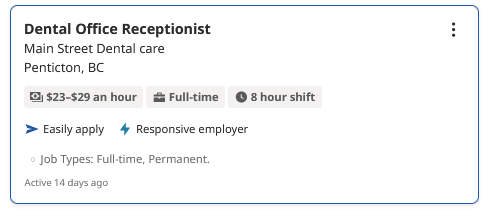

In [8]:
len(cards)

15

### Testing with a Single Record 

Now we need to actually find the relevant information in the HTML code. For this, I essentially used the object/element inspect built-in to most web browsers to find how each piece of information was being stored (a tag, class, span or div object, etc.) and stored it into some variables.

In [9]:
card = cards[0] #Looking at only the first result of our search
atag = card.h2.a

In [10]:
job_title = atag.span.get('title') #get method allows you to extract a property from a class object
job_title

'Yoga and Fusion Instructors'

In [11]:
job_url = "https://ca.indeed.com" + atag.get('href') #Pulling the href atag gives us the relative URL - we need the full URL so we combine it with the base website URL to get the full job posting URL.
job_url

'https://ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BZkp-H2vu-aifWMAfpe2-HmsCX9MQskihc71ByMxf3LYlOCjLuT1rbIx-TJ7IB26NnyYk5fXgTMoqNeUKtq8ZDcUWOqqO1eVt9WGcVes8dJnb6JWMw2rSuVri_oIlYE8wfsUFiYrqd_LQ3T65DRYy0CeZbNGFJuO7W53jAypLYu0fTrKxEPOfhG9GR0ubnmPA_tUX9gCbOB0TK7_1sTP9QCOsQzrf0j-jP6R0mTu2bGcw2PebUwN_ON5Fg-HDdyJVq66XxR_u5fmqf6vI2YfYYaN4eX6iAR_lkKazEloQt_0r8Rcq05OWJiAz854_5Cg2VZVg-Ziug-5F6Q1y7vca4P6PleojyS8LpBJWQU5AMgo933e6Ft8WvgfSipg0C78F3U399OdEveVBpfuCz71qBcOPNR6BRv-tdOXGks8yD13Epigd4YByjq3Lm411OpU16hyaB72bXxo60OKEd8W_uYfE_zhvJVsBYe2aX51J2OA==&xkcb=SoBD-_M3agn_SWWfyh0LbzkdCdPP&p=0&fvj=1&vjs=3'

In [12]:
company_name = card.find('span',{'class':'companyName'}).text.strip() #note that the default value for the find method is class so the dictionary isn't required

In [13]:
company_location = card.find('div','companyLocation').text.strip() #the find method allows you to get the class name

In [14]:
job_summary = card.find('div','job-snippet').text.strip()

In [15]:
post_date = card.find('span','date').text
today = datetime.today().strftime('%Y-%m-%d')

Note that since some jobs have salary values posted and some don't, I used a try except statement to prevent errors.

In [16]:
try:
    job_salary = card.find("div",{'class':'attribute_snippet'}).text.strip()

except AttributeError:
    job_salary = ""

### Generalize the model with a function

Now we can built a card analyzing/scraping function using our previous code.

In [17]:
def get_record(card):
    atag = card.h2.a
    job_title = atag.span.get('title') #get method allows you to extract a property from a class object
    job_url = "ca.indeed.com" + atag.get('href')
    company_name = card.find('span',{'class':'companyName'}).text.strip() #note that the default value for the find method is class so the dictionary isn't required
    company_location = card.find('div','companyLocation').text.strip() #the find method allows you to get the class name
    job_summary = card.find('div','job-snippet').text.strip()
    post_date = card.find('span','date').text
    today = datetime.today().strftime('%Y-%m-%d')
    try:
        job_salary = card.find("div",{'class':'attribute_snippet'}).text.strip()
    except AttributeError:
        job_salary = ""
        
    record = (job_title, company_name, company_location, post_date, today, job_summary, job_salary, job_url)
    
    return record
    

In [18]:
records = []
for card in cards:
    record = get_record(card)
    records.append(record)

In [19]:
records[0]

('Yoga and Fusion Instructors',
 'Oxgyen Yoga and Fitness Victoria',
 'Victoria, BC',
 'EmployerActive 1 day ago',
 '2022-08-21',
 'At least one active designation or certification: 200 hours of Yoga Training, Personal Training, Pilates Training, Group Fitness or other training with a…',
 '$35–$40 an hour',
 'ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BZkp-H2vu-aifWMAfpe2-HmsCX9MQskihc71ByMxf3LYlOCjLuT1rbIx-TJ7IB26NnyYk5fXgTMoqNeUKtq8ZDcUWOqqO1eVt9WGcVes8dJnb6JWMw2rSuVri_oIlYE8wfsUFiYrqd_LQ3T65DRYy0CeZbNGFJuO7W53jAypLYu0fTrKxEPOfhG9GR0ubnmPA_tUX9gCbOB0TK7_1sTP9QCOsQzrf0j-jP6R0mTu2bGcw2PebUwN_ON5Fg-HDdyJVq66XxR_u5fmqf6vI2YfYYaN4eX6iAR_lkKazEloQt_0r8Rcq05OWJiAz854_5Cg2VZVg-Ziug-5F6Q1y7vca4P6PleojyS8LpBJWQU5AMgo933e6Ft8WvgfSipg0C78F3U399OdEveVBpfuCz71qBcOPNR6BRv-tdOXGks8yD13Epigd4YByjq3Lm411OpU16hyaB72bXxo60OKEd8W_uYfE_zhvJVsBYe2aX51J2OA==&xkcb=SoBD-_M3agn_SWWfyh0LbzkdCdPP&p=0&fvj=1&vjs=3')

### Getting the next page

Now to get more than 1 page worth of cards/job postings, we can use the "next" href value stored in the HTML code which is essentially the URL for the next page once we add the full URL to the relative URL. The while true loop makes it so that as long as there is a "Next" href value, the URL value will be updated to the next page and if not we break out of the loop.

In [20]:
while True:
    try:
        url = "https://ca.indeed.com" + soup.find('a',{'aria-label':'Next'}).get('href')
    
    except AttributeError:
        break
    
    url = url.replace(" ","%20")
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    response = urlopen(req).read()
    soup = BeautifulSoup(response, 'html.parser') 
    cards = soup.find_all('div','job_seen_beacon') #Gets the job card objects on a single page
    
    for card in cards:
        record = get_record(card)
        records.append(record)

In [21]:
len(records)

51

### Putting it All Together

Now we can finally put it all together. With a couple of loops, we can iterate over every card on every page for every industry section on Indeed. It takes a little bit of time since I added a time.sleep(0.5) to try and prevent from requests being denied by the server. To speed things up, we could try to remove it and see what happens but for now, it only takes a few minutes to pull the data for the City of Victoria (~2700 rows).

In [22]:
def get_url(position, location, industry):
    """Generate a url from position and location"""
    template = 'https://www.indeed.ca/jobs?q={}&l={}&sc=0kf%3Acmpsec({})%3B'
    url = template.format(position, location, industry)
    return url
    
def get_record(card, industry):
    """Extract job data from a single record"""
    atag = card.h2.a
    job_title = atag.span.get('title') #get method allows you to extract a property from a class object
    job_url = "ca.indeed.com" + atag.get('href')
    company_name = card.find('span',{'class':'companyName'}).text.strip() #note that the default value for the find method is class so the dictionary isn't required
    company_location = card.find('div','companyLocation').text.strip() #the find method allows you to get the class name
    job_summary = card.find('div','job-snippet').text.strip()
    post_date = card.find('span','date').text
    today = datetime.today().strftime('%Y-%m-%d')
    try:
        job_salary = card.find("div",{'class':'attribute_snippet'}).text.strip()
    except AttributeError:
        job_salary = ""
        
    record = (job_title, company_name, company_location, post_date, today, job_summary, job_salary, industry, job_url)
    
    return record    
    

def main(position, location, industry):
    """run the main program routine"""
    records = []
    
    for key in industry.keys():
        url = get_url(position, location, key)
        while True:
            url = url.replace(" ","%20")
            req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
            time.sleep(0.5)
            response = urlopen(req).read()
            soup = BeautifulSoup(response, 'html.parser') 
            cards = soup.find_all('div','job_seen_beacon') #Gets the job card objects on a single page

            for card in cards:
                record = get_record(card, industry.get(key))
                records.append(record)

            try:
                url = "https://ca.indeed.com" + soup.find('a',{'aria-label':'Next'}).get('href')

            except AttributeError:
                break


        with open('job_results_' + datetime.today().strftime('%Y-%m-%d') + '_' +location + ".csv", 'w', newline='', encoding= 'utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['JobTitle','Company','Location','PostDate','ExtractDate','Summary','Salary','Industry','JobUrl'])
            writer.writerows(records)

### Iterate Over All Industries in Victoria

Note that this industry dictionary has the keys and values reversed. This was to simplify looping through each industry in the main() function above. I wanted to record the industry within the dataset while also using the same industry dictionary to loop. There are likely more elegant solutions but this was the simplest working solution I found at the time.

In [92]:
industry = {'48BZP': 'Retail & Wholesale', '22VKN': 'Healthcare', 'W2F4E': 'Restaurants & Food Service', 'NTW8X': 'Construction, Repair & Maintenance Services', 'P634J': 
            'Transportation & Logistics', 'NKR5F': 'Information Technology', 'X42V4': 'Hotel & Travel Accommodation', 'CPGHF': 'Manufacturing', 'ZMM32': 'Non-profit & NGO', 'Q3FC3': 'Human Resources & Staffing', 'B23RH': 
            'Government & Public Administration', 'S7KHR': 'Real Estate', 'MSQWR': 'Finance', 'ZYCW4': 'Personal Consumer Services', 'RFWNN': 'Education', 'JGU5R': 'Telecommunications', 'TAN6J': 'Energy, Mining, Utilities', 'HV5U6': 
            'Aerospace & Defence', '4EWFJ': 'Insurance', '92AZY': 'Management & Consulting', 'N322U': 'Arts, Entertainment & Recreation', 'SVBZF': 'Agriculture', '4DGEF': 'Media & Communication', '5ZM33': 'Pharmaceutical & Biotechnology', '6GW2X': 'Legal'}

main('','Victoria', industry)

### Iterate Over All Industries in Penticton

In [107]:
main('','Penticton', industry)

### Lets Review Our Data

First we'll import pandas to make dataframes out of both of the dataset CSV files we collected. Then we'll group, sort and count the number of jobs per industry to see if it roughly matches what Indeed claims.

In [23]:
import pandas as pd
import numpy as np

Victoria_df = pd.read_csv('job_results_2022-08-06_Victoria.csv')
Penticton_df = pd.read_csv('job_results_2022-08-06_Penticton.csv')

In [24]:
Victoria_df.groupby(['Industry'])['Industry'].count().sort_values(ascending=False) 

Industry
Retail & Wholesale                             517
Healthcare                                     438
Restaurants & Food Service                     257
Construction, Repair & Maintenance Services    240
Transportation & Logistics                     122
Government & Public Administration             101
Non-profit & NGO                                95
Hotel & Travel Accommodation                    94
Manufacturing                                   92
Information Technology                          82
Human Resources & Staffing                      71
Finance                                         68
Education                                       59
Personal Consumer Services                      58
Aerospace & Defence                             56
Real Estate                                     48
Energy, Mining, Utilities                       45
Arts, Entertainment & Recreation                43
Telecommunications                              42
Management & Consultin

In [25]:
Penticton_df.groupby(['Industry'])['Industry'].count().sort_values(ascending=False) 

Industry
Retail & Wholesale                             126
Healthcare                                      99
Restaurants & Food Service                      70
Construction, Repair & Maintenance Services     55
Manufacturing                                   33
Transportation & Logistics                      30
Arts, Entertainment & Recreation                30
Finance                                         29
Non-profit & NGO                                28
Government & Public Administration              15
Human Resources & Staffing                      15
Education                                       14
Energy, Mining, Utilities                       14
Telecommunications                              14
Real Estate                                     13
Insurance                                       13
Hotel & Travel Accommodation                    13
Personal Consumer Services                       9
Media & Communication                            6
Management & Consultin

## Interesting Point Here

Interesting. On the end page of every job search Indeed has a disclaimer saying: "We have removed 'X number' job postings very similar to those already shown. To see these additional results, you may repeat your search with the omitted job postings included." After revealing some of these hidden job postings, they appeared to be irrelevant to the industry tag.

Upon initial investigation, based on the number of jobs from each industry we actually scraped, it looks like Indeed recycles job posting between each industry to inflate the job posting numbers their website actually has. However, I would need to look into this further to confirm.

See below for screenshots from Indeed showing the number of job postings under each industry tag. 

Victoria | Penticton
- | - 
![Victoria](./Indeed_Victoria_Jobs_20220806.png) | ![Penticton](./Indeed_Penticton_Jobs_20220806.png)


## Time for Some Data Cleaning

### Preview our Data

It looks like there are a few issues with our Salary data. 

1. When no salary data was available, it looks like Indeed instead stores whether the job is Full-time or Part-time instead.
2. When the Full-time and Part-time values are stored, it looks like some of them have a +1, +2, etc. value next to them. This could be because there are multiple positions. We'll need to remove this number down the line as it causes some errors in the data filtering.
3. This was to be expected - the salary data ranges from hourly, monthly, daily, yearly, etc. To simplify things, we'll convert everything to a yearly salary.
4. The salary data also has ranges for some jobs. In order to make these easier to work with, we'll just take the average of the range.

In [26]:
Victoria_df.tail(20)

,JobTitle,Company,Location,PostDate,ExtractDate,Summary,Salary,Industry,JobUrl
2662,Full Time Pharmacy Assistant,Heart Pharmacy Group Owned by Naz Rayani,"Victoria, BC+2 locations",PostedPosted 14 days ago,2022-08-06,Operate the cash register as needed.\nBe carin...,Full-time,Pharmaceutical & Biotechnology,ca.indeed.com/rc/clk?jk=8efb825a5a91fddc&fccid...
2663,Customer Service - Cashier,Heart Pharmacy Group Owned by Naz Rayani,"Victoria, BC",PostedPosted 2 days ago,2022-08-06,Operate cash registers - receive payment in th...,Part-time +1,Pharmaceutical & Biotechnology,ca.indeed.com/rc/clk?jk=98563d1b92217c35&fccid...
2664,Diagnostics Liaison - Western Canada,AstraZeneca,"Hybrid remote in Victoria, BC",PostedPosted 30+ days ago,2022-08-06,Undergraduate degree; preferably an Advanced d...,Full-time,Pharmaceutical & Biotechnology,ca.indeed.com/rc/clk?jk=dda171ba86e63eee&fccid...
2665,"Territory Manager, Specialty Care, Injectables...",GSK,"Victoria, BC",PostedPosted 30+ days ago,2022-08-06,"However, to be eligible for this position and ...",NaN,Pharmaceutical & Biotechnology,ca.indeed.com/rc/clk?jk=d210030a9899e967&fccid...
2666,Remote Job - PhD Scientific Content Writer for...,Supreme Optimization,Remote in Canada,EmployerActive 14 days ago,2022-08-06,Who we’re looking for: * Hiring a content writ...,"$75,000–$120,000 a year",Pharmaceutical & Biotechnology,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DBr...
2667,Merchandiser / Receiver,Heart Pharmacy Group Owned by Naz Rayani,"Victoria, BC",PostedPosted 30 days ago,2022-08-06,Operate cash register as necessary.\nResponsib...,Full-time,Pharmaceutical & Biotechnology,ca.indeed.com/rc/clk?jk=548ccbd3559246f9&fccid...
2668,Paralegal,Acheson Sweeney Foley Sahota LLP,"Victoria, BC",PostedPosted 4 days ago,2022-08-06,You will be responsible for running a file loa...,"$70,000–$90,000 a year",Legal,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DMd...
2669,Litigation Legal Assistant,Carfra Lawton LLP,"Hybrid remote in Victoria, BC",PostedPosted 15 days ago,2022-08-06,"We offer a very competitive salary, extended b...",Full-time,Legal,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0DAQ...
2670,Legal Assistant,Vangenne & Company,"Victoria, BC",PostedToday,2022-08-06,Filing at the courthouse and filing online.\nW...,$25–$37 an hour,Legal,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CLm...
2671,Family Law Legal Assistant,League and Williams Lawyers,"Victoria, BC",PostedPosted 30+ days ago,2022-08-06,Some legal assistant experience (2 or more yea...,"$42,041–$70,000 a year",Legal,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0Ddz...


As you can see, we've gotten rid of the "+ 1", "+ 2", etc. values stored in the salary column. To make the salaries a valid float value, we also stripped out all the commas.

In [27]:
Victoria_df['Salary'] = Victoria_df['Salary'].str.replace('\+.*$', '', regex = True) #Deletes the +1, +2, +3, etc. I believe this is actually refering to the number of positions. For some reason Indeed decided to store it in the same place as the salary information.
Victoria_df['Salary'] = Victoria_df['Salary'].str.replace(',', '', regex = True) #Turns the longer salaries into workable format
Victoria_df.tail()

,JobTitle,Company,Location,PostDate,ExtractDate,Summary,Salary,Industry,JobUrl
2677,Festival Security Staff - Laketown Rockfest & ...,JTF SECURITY GROUP,"Victoria, BC",PostedPosted 22 days ago,2022-08-06,Security Guards - with a Valid BC license.\nEv...,$18–$25 an hour,Legal,ca.indeed.com/company/JTF-Security/jobs/Festiv...
2678,early childhood educator assistant,Swift Connect INC,"Victoria, BC",PostedPosted 16 days ago,2022-08-06,Support early childhood educators in carrying ...,$18 an hour,Legal,ca.indeed.com/rc/clk?jk=4b86a90518064bda&fccid...
2679,early childhood educator (E.C.E.),Swift Connect INC,"Victoria, BC",PostedPosted 16 days ago,2022-08-06,Develop and implement child-care programs that...,$22–$24 an hour,Legal,ca.indeed.com/rc/clk?jk=8d15da3133e8c995&fccid...
2680,Retail Security Officer,JTF SECURITY GROUP,"Langford, BC",PostedPosted 29 days ago,2022-08-06,British Columbia security license (required).\...,$18 an hour,Legal,ca.indeed.com/company/JTF-Security/jobs/Retail...
2681,Part-Time Merchandiser - Victoria,PepsiCo,"Victoria, BC",PostedPosted 30+ days ago,2022-08-06,You hold a valid Class 5 license and have acce...,Part-time,Legal,ca.indeed.com/rc/clk?jk=96c11ad6392b3053&fccid...


This one is a bit more confusing. The Regex here takes all continuous digits, including decimals or non-decimals. Any digits part of a range get stored in a separate sub-row. Then we unstack or pivot all these subrows into individual rows by taking their mean and finally store it under the "Average_Wage" variable.

In [28]:
Victoria_df['Average_Wage'] = Victoria_df['Salary'].str.extractall('(\d+\.?\d*|\.\d+)')[0].unstack().astype(float).mean(1)

In [29]:
Victoria_df.tail(10)

,JobTitle,Company,Location,PostDate,ExtractDate,Summary,Salary,Industry,JobUrl,Average_Wage
2672,Kitchen Leader,Ramen Arashi,"Victoria, BC",PostedPosted 30+ days ago,2022-08-06,"Ensure quality customer service, including add...",$17 an hour,Legal,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0B_h...,17.00
2673,Ironworker Erector,Corporate Support Services,Canada,Hiring ongoing,2022-08-06,Must have a minimum of Grade 12 diploma or equ...,$48.66 an hour,Legal,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CW4...,48.66
2674,Auditor,The Law Society of British Columbia,"Hybrid remote in Victoria, BC",PostedPosted 15 days ago,2022-08-06,"As travel is required, the successful candidat...",$94605–$102831 a year,Legal,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0BsA...,98718.00
2675,Administrative Legal Assistant/Intake Legal As...,Legal Aid BC,"Victoria, BC",PostedPosted 19 days ago,2022-08-06,Legal Aid BC (LABC) is a non-profit organizati...,Full-time,Legal,ca.indeed.com/company/Legal-Aid-BC/jobs/Admini...,NaN
2676,infants' daycare worker,Swift Connect INC,"Victoria, BC",PostedPosted 16 days ago,2022-08-06,Develop and implement child-care programs that...,$24–$26 an hour,Legal,ca.indeed.com/rc/clk?jk=572d62c371546006&fccid...,25.00
2677,Festival Security Staff - Laketown Rockfest & ...,JTF SECURITY GROUP,"Victoria, BC",PostedPosted 22 days ago,2022-08-06,Security Guards - with a Valid BC license.\nEv...,$18–$25 an hour,Legal,ca.indeed.com/company/JTF-Security/jobs/Festiv...,21.50
2678,early childhood educator assistant,Swift Connect INC,"Victoria, BC",PostedPosted 16 days ago,2022-08-06,Support early childhood educators in carrying ...,$18 an hour,Legal,ca.indeed.com/rc/clk?jk=4b86a90518064bda&fccid...,18.00
2679,early childhood educator (E.C.E.),Swift Connect INC,"Victoria, BC",PostedPosted 16 days ago,2022-08-06,Develop and implement child-care programs that...,$22–$24 an hour,Legal,ca.indeed.com/rc/clk?jk=8d15da3133e8c995&fccid...,23.00
2680,Retail Security Officer,JTF SECURITY GROUP,"Langford, BC",PostedPosted 29 days ago,2022-08-06,British Columbia security license (required).\...,$18 an hour,Legal,ca.indeed.com/company/JTF-Security/jobs/Retail...,18.00
2681,Part-Time Merchandiser - Victoria,PepsiCo,"Victoria, BC",PostedPosted 30+ days ago,2022-08-06,You hold a valid Class 5 license and have acce...,Part-time,Legal,ca.indeed.com/rc/clk?jk=96c11ad6392b3053&fccid...,NaN


For our analysis, let's drop all the rows with no salary data since this is what we're interested in.

In [30]:
Victoria_df.dropna(subset=['Average_Wage'], inplace=True)
Victoria_df.reset_index(drop=True, inplace=True)
Victoria_df.head()

,JobTitle,Company,Location,PostDate,ExtractDate,Summary,Salary,Industry,JobUrl,Average_Wage
0,Cannabis Sales Associate,Clarity Canna,"Victoria, BC",PostedPosted 11 days ago,2022-08-06,The best crew to work with!!!.\nPart-time hour...,From $19 an hour,Retail & Wholesale,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AJW...,19.0
1,General Clerk,Save-On-Foods,"Victoria, BC+1 location",PostedPosted 3 days ago,2022-08-06,"An organization that supports local growers, p...",$16.20 an hour,Retail & Wholesale,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0A_E...,16.2
2,Sales Associate,Just Cozy,"Victoria, BC",PostedPosted 6 days ago,2022-08-06,The Sales Associate maximizes sales by deliver...,From $16 an hour,Retail & Wholesale,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0B5n...,16.0
3,Service Advisor,Tesla,"Victoria, BC",PostedPosted 24 days ago,2022-08-06,Must have and maintain a valid driver’s licens...,$24–$27 an hour,Retail & Wholesale,ca.indeed.com/company/Tesla/jobs/Service-Advis...,25.5
4,Cashier,Save-On-Foods,"Victoria, BC+2 locations",PostedPosted 10 days ago,2022-08-06,"An organization that supports local growers, p...",$16.20 an hour,Retail & Wholesale,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0A_E...,16.2


Now we can normalize all of our average wage values into average yearly salaries. This makes quite a few assumptions: it assumes everyone is working 52 weeks for 5 days per week at 8 hours per day and that there are no statutory holidays. This is obviously not the case for many of these jobs however it gives us a good comparative value between all the jobs. 

In [31]:
m1 = Victoria_df['Salary'].str.contains('month')
m2 = Victoria_df['Salary'].str.contains('day')
m3 = Victoria_df['Salary'].str.contains('hour')
Victoria_df['Average_Yearly_Salary'] =np.select([m1, m2, m3],  #Assuming average of 260 work days in a year
                          [Victoria_df['Average_Wage'] * 8.56 , Victoria_df['Average_Wage'] * 260, Victoria_df['Average_Wage'] * 8 * 260], default=Victoria_df['Average_Wage'])

In [32]:
Victoria_df.head()

,JobTitle,Company,Location,PostDate,ExtractDate,Summary,Salary,Industry,JobUrl,Average_Wage,Average_Yearly_Salary
0,Cannabis Sales Associate,Clarity Canna,"Victoria, BC",PostedPosted 11 days ago,2022-08-06,The best crew to work with!!!.\nPart-time hour...,From $19 an hour,Retail & Wholesale,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0AJW...,19.0,39520.0
1,General Clerk,Save-On-Foods,"Victoria, BC+1 location",PostedPosted 3 days ago,2022-08-06,"An organization that supports local growers, p...",$16.20 an hour,Retail & Wholesale,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0A_E...,16.2,33696.0
2,Sales Associate,Just Cozy,"Victoria, BC",PostedPosted 6 days ago,2022-08-06,The Sales Associate maximizes sales by deliver...,From $16 an hour,Retail & Wholesale,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0B5n...,16.0,33280.0
3,Service Advisor,Tesla,"Victoria, BC",PostedPosted 24 days ago,2022-08-06,Must have and maintain a valid driver’s licens...,$24–$27 an hour,Retail & Wholesale,ca.indeed.com/company/Tesla/jobs/Service-Advis...,25.5,53040.0
4,Cashier,Save-On-Foods,"Victoria, BC+2 locations",PostedPosted 10 days ago,2022-08-06,"An organization that supports local growers, p...",$16.20 an hour,Retail & Wholesale,ca.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0A_E...,16.2,33696.0


Now let's repeat all the same cleaning for the Penticton dataset.

In [33]:
Penticton_df['Salary'] = Penticton_df['Salary'].str.replace('\+.*$', '', regex = True) #Deletes the +1, +2, +3, etc. I believe this is actually refering to the number of locations. For some reason Indeed decided to store it in the same place as the salary information.
Penticton_df['Salary'] = Penticton_df['Salary'].str.replace(',', '', regex = True) #Turns the longer salaries into workable format

Penticton_df['Average_Wage'] = Penticton_df['Salary'].str.extractall('(\d+\.?\d*|\.\d+)')[0].unstack().astype(float).mean(1)
Penticton_df.dropna(subset=['Average_Wage'], inplace=True)
Penticton_df.reset_index(drop=True, inplace=True)
m1 = Penticton_df['Salary'].str.contains('month')
m2 = Penticton_df['Salary'].str.contains('day')
m3 = Penticton_df['Salary'].str.contains('hour')
Penticton_df['Average_Yearly_Salary'] =np.select([m1, m2, m3],  #Assuming average of 260 work days in a year
                          [Penticton_df['Average_Wage'] * 8.56 , Penticton_df['Average_Wage'] * 260, Penticton_df['Average_Wage'] * 8 * 260], default=Penticton_df['Average_Wage'])


## Basic Statistics

Let's take a look at a few statistics of our datasets. 

Let's take a quick look at what the average yearly salary is in Victoria, BC based on 1245 job postings (with available salary) from Indeed in August of 2022.

In [34]:
Victoria_df['Average_Yearly_Salary'].describe()

count      1245.000000
mean      52807.449221
std       22225.868424
min       31616.000000
25%       39520.000000
50%       46342.400000
75%       56500.000000
max      312000.000000
Name: Average_Yearly_Salary, dtype: float64

Let's take a quick look at what the average yearly salary is in Victoria, BC based on 270 job postings (with available salary) from Indeed in August of 2022.

In [35]:
Penticton_df['Average_Yearly_Salary'].describe()

count       270.000000
mean      58317.470074
std       51134.721250
min       31616.000000
25%       37440.000000
50%       46103.200000
75%       54080.000000
max      400000.000000
Name: Average_Yearly_Salary, dtype: float64

Putting it all together in a table to simplify comparisons.

In [42]:
stats_table = pd.DataFrame({'Victoria Salary': Victoria_df['Average_Yearly_Salary'].describe()}).round()
stats_table['Penticton Salary'] = Penticton_df['Average_Yearly_Salary'].describe().round()
stats_table['% Difference']  = ((stats_table['Victoria Salary']-stats_table['Penticton Salary'])/stats_table['Victoria Salary'] * 100).round()


stats_table = stats_table.reset_index()

stats_table

,index,Victoria Salary,Penticton Salary,% Difference
0,count,1245.0,270.0,78.0
1,mean,52807.0,58317.0,-10.0
2,std,22226.0,51135.0,-130.0
3,min,31616.0,31616.0,0.0
4,25%,39520.0,37440.0,5.0
5,50%,46342.0,46103.0,1.0
6,75%,56500.0,54080.0,4.0
7,max,312000.0,400000.0,-28.0


It looks like the median salary is ~$46,000 in both Penticton and Victoria. Note that this is likely an overestimate due to the assumption that people are working 52 weeks of work, 5 days a week at 8 hours a day throughout the year.

It's also important to note that the median is arguably a more representative statistic of what the the average person tends to earn than the mean in this case.

Below we can see the median yearly salary by industry for both Victoria and Penticton (sorted in descending order first by Victoria and second by Penticton). In general, it appears that median yearly salaries in most industries are comparable between Victoria and Penticton.

In [43]:
Victoria_Avg_Salary_Industry = Victoria_df.groupby(by=["Industry"])["Average_Yearly_Salary"].median()

Penticton_Avg_Salary_Industry = Penticton_df.groupby(by=["Industry"])["Average_Yearly_Salary"].median()

Salary_delta = Victoria_Avg_Salary_Industry - Penticton_Avg_Salary_Industry

Salary_ratio = Victoria_Avg_Salary_Industry / Penticton_Avg_Salary_Industry

Salary_by_industry = pd.concat([Victoria_Avg_Salary_Industry, Penticton_Avg_Salary_Industry, Salary_delta, Salary_ratio], keys = ['Victoria','Penticton', 'Difference','Ratio'], axis=1)

Salary_by_industry = Salary_by_industry.sort_values(by=['Victoria', 'Penticton'], ascending=False)

Salary_by_industry

,Victoria,Penticton,Difference,Ratio
Industry,,,,
Real Estate,62500.0,43680.00,18820.00,1.430861
Insurance,59000.0,119400.00,-60400.00,0.494137
Healthcare,53726.4,49108.80,4617.60,1.094028
Transportation & Logistics,52520.0,51896.00,624.00,1.012024
Government & Public Administration,52260.0,53449.75,-1189.75,0.977741
Legal,52000.0,69326.40,-17326.40,0.750075
Telecommunications,52000.0,47840.00,4160.00,1.086957
"Construction, Repair & Maintenance Services",51090.0,54080.00,-2990.00,0.944712
Human Resources & Staffing,50000.0,53056.00,-3056.00,0.942400


Below we can see the number of job postings by industry for both Victoria and Penticton (sorted in descending order first by Victoria and second by Penticton). On average, Victoria has approximately **4.6 times** (1245/270) more job postings than Penticton.

This is interesting to note because based on the regions searched, there appears to be approximately **4.4 times** more people in Victoria than Penticton. This is based on the population of 397,237 people in the Greater Victoria area and 90,178 in the Regional District of Okanagan-Similkameen. Note that both of these regions approximately comprise the default 25km geographical search radius that Indeed performs when searching for jobs in a location.

However, we can see that there are more positions per capita in desirable industries such as Healthcare, Government and Public Admninistration, Information Technology, HR & Staffing, etc. 

In [44]:
Victoria_Job_Count_Industry = Victoria_df.groupby(by=["Industry"])["Industry"].count()

Penticton_Job_Count_Industry = Penticton_df.groupby(by=["Industry"])["Industry"].count()

Job_delta = Victoria_Job_Count_Industry - Penticton_Job_Count_Industry

Job_ratio = Victoria_Job_Count_Industry / Penticton_Job_Count_Industry

Count_by_industry = pd.concat([Victoria_Job_Count_Industry, Penticton_Job_Count_Industry, Job_delta, Job_ratio], keys = ['Victoria','Penticton', 'Difference','Ratio'], axis=1)

Count_by_industry = Count_by_industry.sort_values(by=['Victoria', 'Penticton'], ascending=False)

Count_by_industry

,Victoria,Penticton,Difference,Ratio
Industry,,,,
Healthcare,259,34,225,7.617647
Restaurants & Food Service,194,38,156,5.105263
"Construction, Repair & Maintenance Services",112,29,83,3.862069
Retail & Wholesale,107,35,72,3.057143
Transportation & Logistics,77,16,61,4.812500
Hotel & Travel Accommodation,69,8,61,8.625000
Government & Public Administration,67,8,59,8.375000
Non-profit & NGO,66,26,40,2.538462
Human Resources & Staffing,49,5,44,9.800000


### What does this mean?

What does this mean? I would argue that in general, Victoria does not appear to have a significantly higher number of jobs per capita than Penticton. Furthermore, the lower quartile, median and upper quartile salaries in both datasets appear to be within 5% of one another.


## Data Visualization


My favorite visualization library in Python is by far Seaborn - so let's import Seaborn.

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

A violinplot is a great way of visualizing the distribution of salary within each industry.

Violin plots have many of the same summary statistics as box plots:

    the white dot represents the median
    the thick gray bar in the center represents the interquartile range
    the thin gray line represents the rest of the distribution, except for points that are determined to be “outliers” using a method that is a function of the interquartile range.

On each side of the gray line is a kernel density estimation to show the distribution shape of the data. Wider sections of the violin plot represent a higher probability that members of the population will take on the given value; the skinnier sections represent a lower probability.

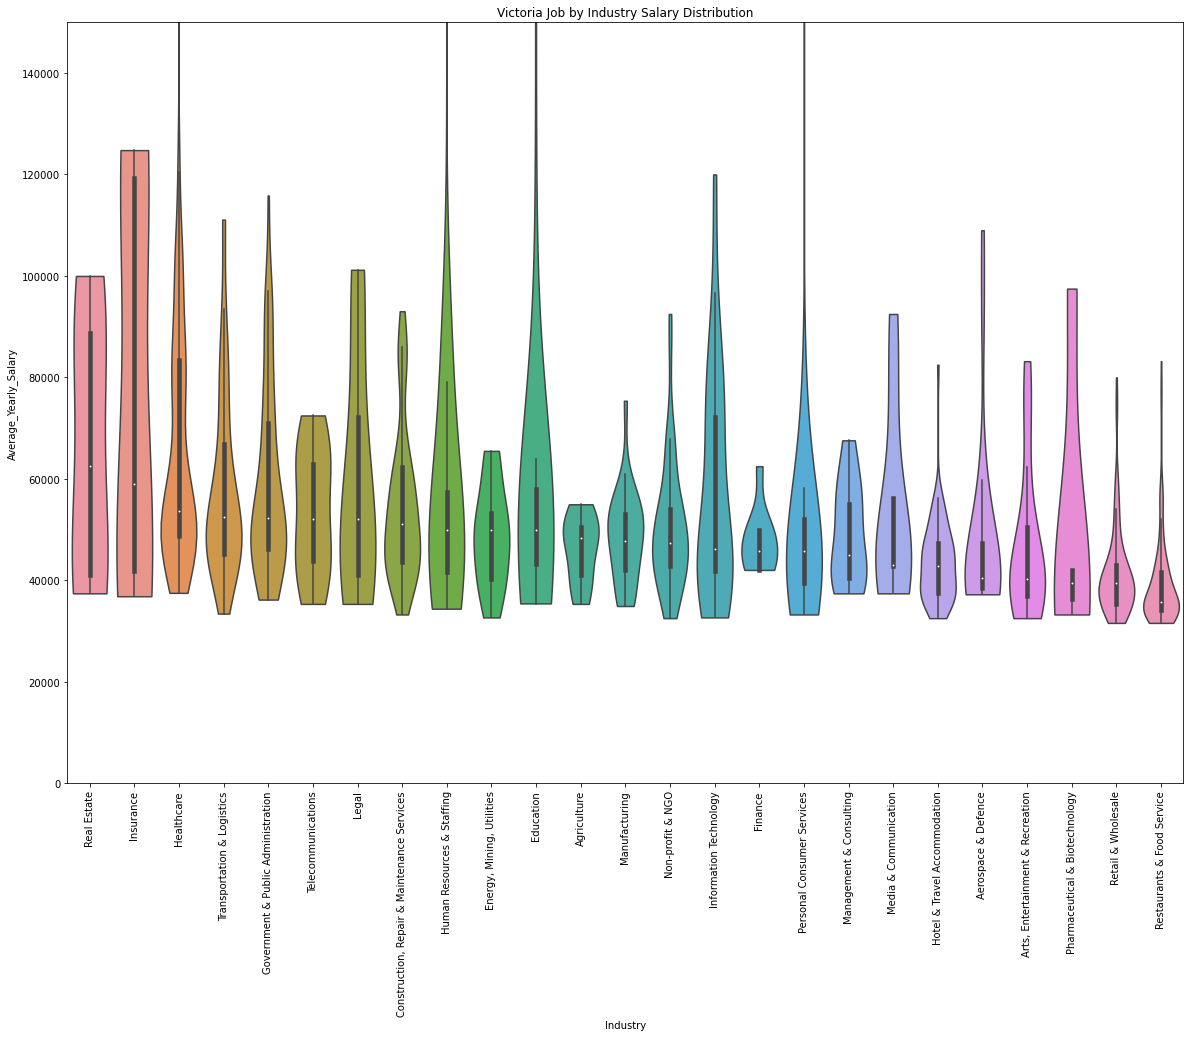

In [54]:
# plot Victoria Salary by Industry distribution
plt.figure(figsize=(20,14))
plt.xticks(rotation='vertical')
plt.ylim(0, 150000)
plt.title('Victoria Job by Industry Salary Distribution')
my_order = Victoria_df.groupby(by=["Industry"])["Average_Yearly_Salary"].median().sort_values(ascending=False).index
violinplot = sns.violinplot(x=Victoria_df["Industry"], y=Victoria_df["Average_Yearly_Salary"], data=pd.melt(Victoria_df), scale='width', cut=0, order=my_order)
plt.show()

The above violin plot shows the relationship of average yearly salary by job industry for all job industries in Victoria. The box plot elements show the median salary Restaurants & Food Service is lower than all other industries in Victoria. The shape of the distribution (extremely skinny at the top and wide in the middle) indicates the salaries of Restaurants & Food Service jobs are highly concentrated around the median. By contrast, the Real Estate industry has the highest median salary with an almost rectangular shape. This indicates that the salaries vary more or less evenly across the full distribution. 

It is unsurprising that Victoria has high real estate job salaries based on the very active real estate market in this area over the past years.

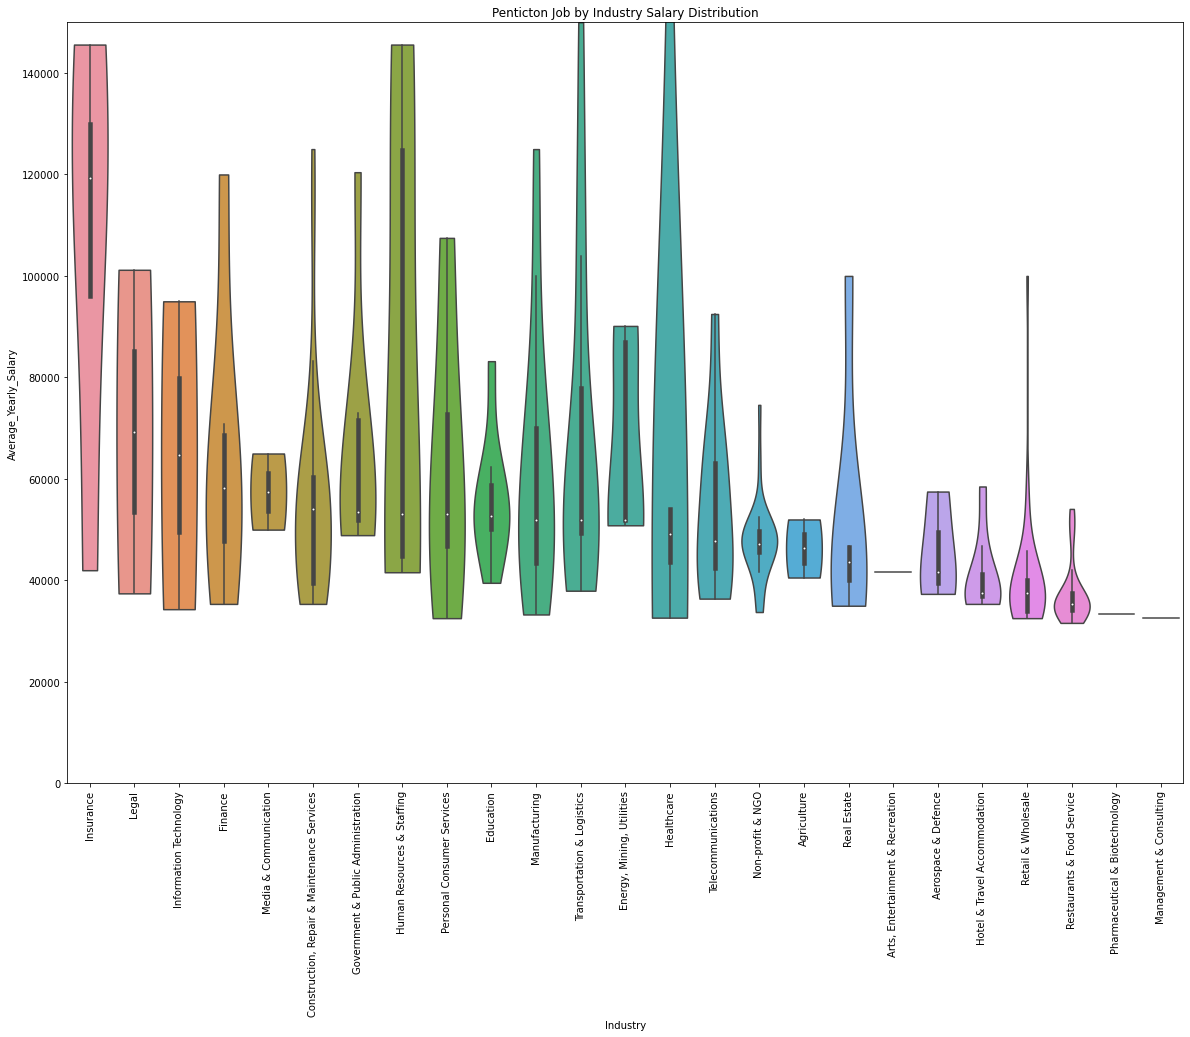

In [53]:
# plot Penticton Salary by Industry distribution
plt.figure(figsize=(20,14))
plt.xticks(rotation='vertical')
plt.ylim(0, 150000)
plt.title('Penticton Job by Industry Salary Distribution')
my_order = Penticton_df.groupby(by=["Industry"])["Average_Yearly_Salary"].median().sort_values(ascending=False).index
violinplot = sns.violinplot(x=Penticton_df["Industry"], y=Penticton_df["Average_Yearly_Salary"], data=pd.melt(Penticton_df), scale='width', cut=0, order=my_order)

The above violin plot shows the relationship of average yearly salary by job industry for all job industries in Penticton. The box plot elements show the median salary Restaurants & Food Service is lower than all other industries in Penticton. The shape of the distribution (extremely skinny at the top and wide in the middle) indicates the salaries of Restaurants & Food Service jobs are highly concentrated around the median. By contrast, the Insurance industry has the highest median salary with a skinny bottom and wider top shape. This indicates that the salaries a little bit but tend to stay around the median or slightly above the median. 

It is surprising that Penticton has significantly higher paying Insurance jobs that Victoria. However, it is important to note that these datasets are simply a "snapshot" of the job postings in each location and only acount for those with posted salaries.

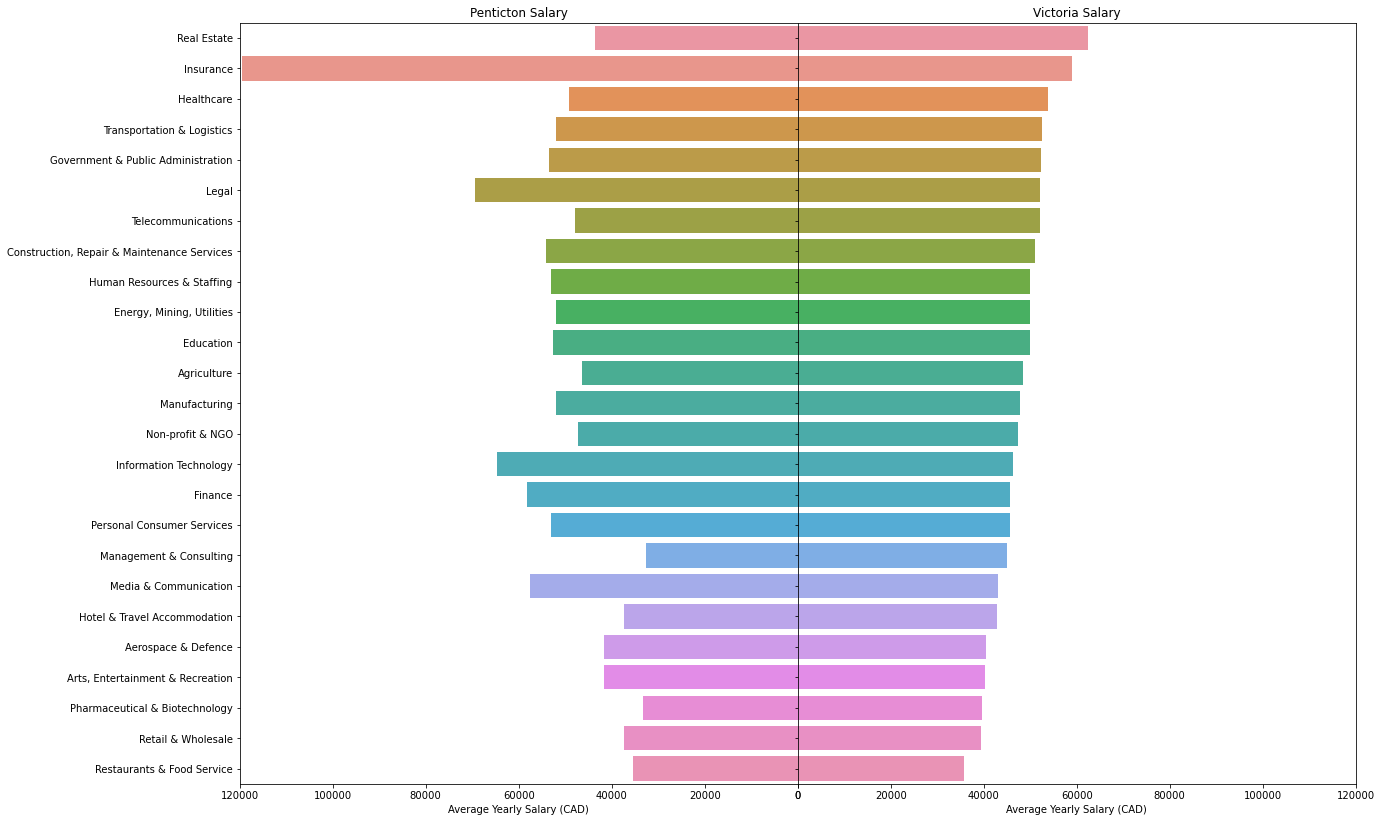

In [55]:
fig, axes = plt.subplots(ncols=2, sharey=True)

fig.set_figheight(14)
fig.set_figwidth(20)

plt.subplots_adjust(wspace=0, hspace=0)

bar_plot = sns.barplot(x='Penticton', y=Salary_by_industry.index, data=Salary_by_industry, ci=None, order=Salary_by_industry.index,  ax=axes[0])
bar_plot = sns.barplot(x='Victoria', y=Salary_by_industry.index, data=Salary_by_industry, ci=None, order=Salary_by_industry.index,  ax=axes[1])

axes[0].set_xlim(0, 120000)
axes[0].invert_xaxis()

axes[1].set_xlim(0, 120000)


axes[0].set(xlabel="Average Yearly Salary (CAD)", ylabel=None, title = "Penticton Salary")
axes[1].set(xlabel="Average Yearly Salary (CAD)", ylabel=None, title = "Victoria Salary")

plt.show()

Above we can see a comparison of average yearly salaries by industry type. Again, the salary distributions are fairly comparable. It is interesting to note that the salary distributions in Penticton appear to vary more from industry to industry. This could be due to the smaller sample size compared to Victoria.

To make fair comparison between the job counts in Penticton compared to Victoria, I decided to standardize Victoria's job count by dividing it by the population ratio of Victoria to Penticton. That is 397,237/90,178 = 4.4. My first attempt was to simply do a population per capita graph, however, the small decimal numbers don't make for very interesting visualizations. Instead, by dividing Victoria's job count by the ratio of the two populations, we get a normalized job count that allows for a more fair comparison between the two areas.

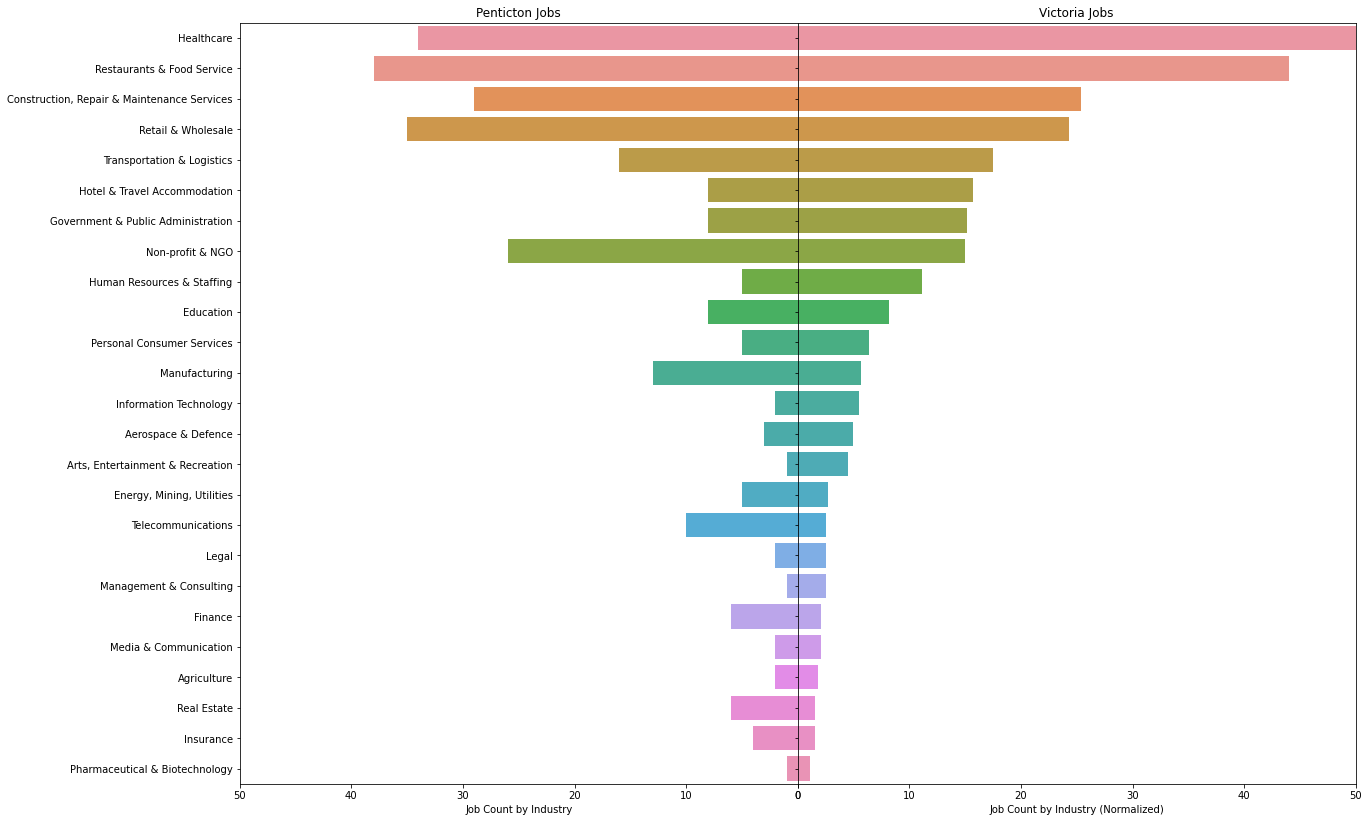

In [58]:
fig, axes = plt.subplots(ncols=2, sharey=True)

fig.set_figheight(14)
fig.set_figwidth(20)

plt.subplots_adjust(wspace=0, hspace=0)

bar_plot = sns.barplot(x='Penticton', y=Count_by_industry.index, data=Count_by_industry, ci=None, order=Count_by_industry.index,  ax=axes[0])
bar_plot = sns.barplot(x=Count_by_industry['Victoria']/4.40503226951, y=Count_by_industry.index, data=Count_by_industry, ci=None, order=Count_by_industry.index,  ax=axes[1])

axes[0].set_xlim(0, 50)
axes[0].invert_xaxis()

axes[1].set_xlim(0, 50)


axes[0].set(xlabel="Job Count by Industry", ylabel=None, title = "Penticton Jobs")
axes[1].set(xlabel="Job Count by Industry (Normalized)", ylabel=None, title = "Victoria Jobs")

plt.show()

Above we can see a comparison of job counts between the two areas by industry type (with normalized job counts for Victoria). It is interesting to note that both areas appear to have a relatively high count of healthcare jobs. This could potentially be attributed to the aging population in both locations but would have to be further investigated to confirm. Another important note is that Restaurant & Food Service jobs appear to be some of the most numerous jobs in both areas while being some of the least paying. This does not take into acount gratuity/tips as these would typically not be reported in the job salary. 

Below is a non-standardized comparison of the two locations. As we can see, it's difficult to objectively compare the two in this visualization since Victoria has a larger population which typically equates to more jobs.

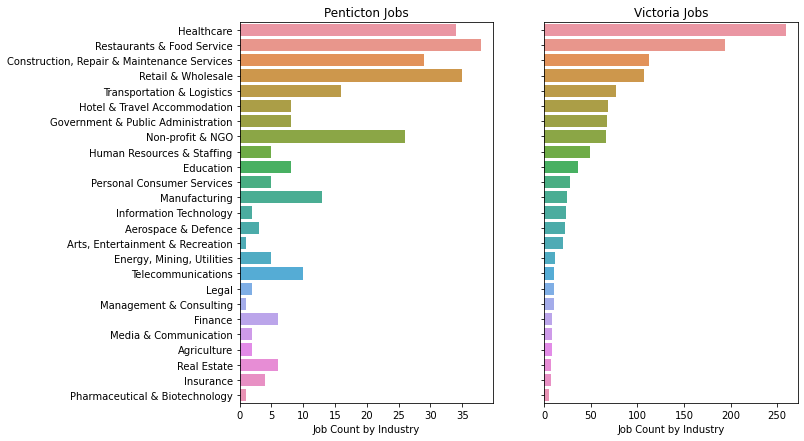

In [60]:
fig, axes = plt.subplots(ncols=2, sharey=True)

fig.set_figheight(7)
fig.set_figwidth(10)

bar_plot = sns.barplot(x='Penticton', y=Count_by_industry.index, data=Count_by_industry, ci=None, order=Count_by_industry.index,  ax=axes[0])
bar_plot = sns.barplot(x=Count_by_industry['Victoria'], y=Count_by_industry.index, data=Count_by_industry, ci=None, order=Count_by_industry.index,  ax=axes[1])

axes[0].set(xlabel="Job Count by Industry", ylabel=None, title = "Penticton Jobs")
axes[1].set(xlabel="Job Count by Industry", ylabel=None, title = "Victoria Jobs")

plt.show()

## Summary

In general, there does not appear to be substantial evidence of higher job availability or higher job salary in Victoria compared to Penticton. However, it is important to note that both locations have higher respective job counts in different industries. This could mean that there is higher job counts in better paying or more desirable industries in Victoria/Penticton.

### Further Analysis/Next Steps

There are so many interesting questions and thoughts that arose through completing this exploratory data analysis:

1. Exploring whether Indeed's self-reported job counts are inflated/accurate or not.
   This would involve comparing job counts across many different search results for different jobs, areas, etc. Then pulling the data by scraping and comparing the job counts.
   <br>
2. Further exploration into cost of living vs salary for both places
   By introducing a cost of living analysis into this work, we could potentially truly beging to understand which place would be most desirable to live from a financial standpoint for the average person. 
   <br>
3. Exploring which job types tend to post salaries. 
   This could start by simply comparing which industries had salaries posted. However, I would also be curious to see if we could use NLP and some machine learning models to search for words such as "entry-level", "junior", etc. and compare to words such as "manager", "senior", etc. By doing this we could potentially being to explore    whether "senior" jobs or "junior" jobs tend to post more salary information.
   <br>
4. Confirming Indeed's industry classification. 
   Using logistic regression and NLP, we could attempt to confirm whether Indeed classified the jobs into appropriate categories. This would be an interesting exercise to use for supervised learning as we could train a model based on Indeed's assigned classes.
   <br>
5. Salary Prediction Model
   Training a model to try to determine salaries of any job posting based on Job Title, Industry and keywords from the Job Summary/Description. It would be interesting to train this model using jobs with posted salaries and seeing if it could be accurate. 
